
## Predictive richness maps
### authors: Javier Lopatin & Klara Dolos
### mail: javierlopatin@gmail.com, klara.dolos@kit.de
### Manuscript: Comparing Generalized Linear Models and random forest to model vascular plant species richness using LiDAR data in a natural forest in central Chile
### last changes: 12/11/2015
## ==============================================================

### load the require packages

In [26]:
pkgs<-c("rgdal", "raster", "MASS", "alphahull", "GISTools", "tripack")
lapply(pkgs, require, character.only=T)

Loading required package: tripack


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

In [6]:
# set working directory
setwd("C:/Users/Lopatin/Dropbox/Publicaciones/SpeciesRichness-GLMvsRF-LiDAR")

# Load data 
# data1 have the observations and predictors at plot level, while data2 have the predictors in a systematic grid of 30m x 30m
# Both data must have the same column, names and order 
data1 <- read.table("Richness_model.csv", header=T, sep=",", dec=".") 
attach(data1)
data2<-read.csv("Maps.csv", header=T, sep=",", dec=".")
attach(data2)

The following objects are masked from data1:

    DTM_1_mean, ID, one_mean, slope_1m_std



In [ ]:
# load grid shapefile
polyg<-readOGR(".","Grid_30m_c")

In [ ]:
# Convert predictors to raster format
Pred_ras<- merge(polyg, data2, by.x="ID", by.y="ID")
r <- raster(extent(Pred_ras))
res(r)=30
Mean_DTM <- rasterize(Pred_ras, field="DTM_1_mean", r)
Mean_DCM <- rasterize(Pred_ras, field="one_mean", r)
STD_Slope <- rasterize(Pred_ras, field="slope_1m_std", r)

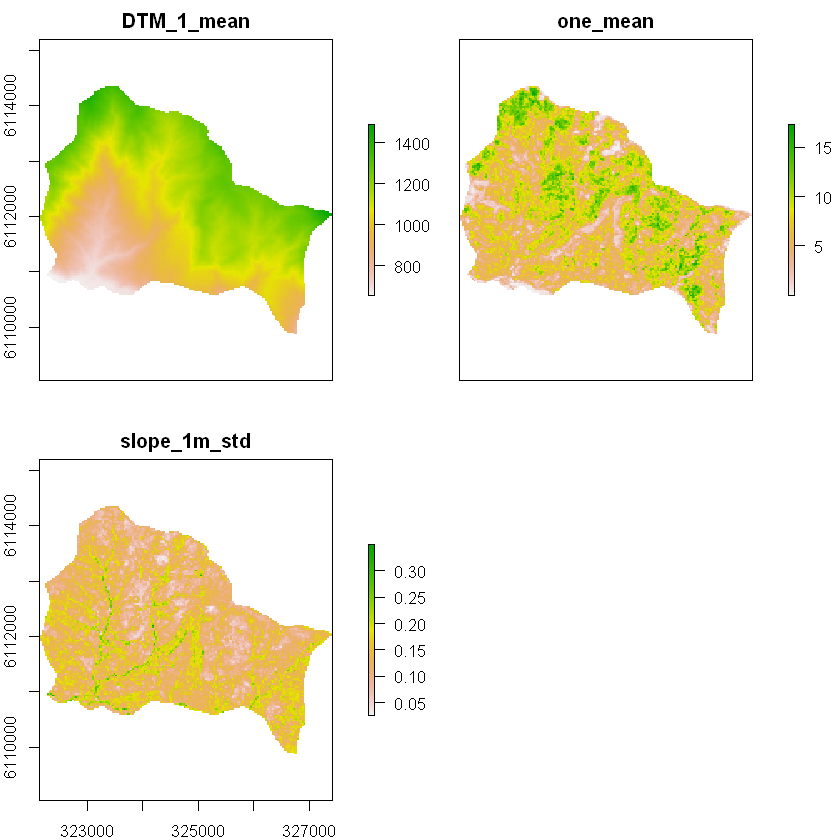

In [8]:
# Stack the predictors
predictors<-stack(Mean_DTM, Mean_DCM, STD_Slope)  
names(predictors) <- c("DTM_1_mean", "one_mean", "slope_1m_std") # Use the same names than in the data
plot(predictors)

###  Train the models using all observations of data1

In [29]:
######### Total ##########
ms <- glm(Total_richness ~ one_mean + DTM_1_mean + slope_1m_std, data=data1, family=negative.binomial(theta=1 , link="log"))
preds_T <- predict(predictors, ms, type="response")

### Create mask as convex hull around the environemntal space available in the field data using the DTM and DCM information.
tr.dat <- list(x=data1$one_mean, y=data1$DTM_1_mean)  # two dimensions

# MASK!, Remove or change the -2 factors in tr.dat$x and tr.dat$y to manage the mask area
tri<-tri.mesh(tr.dat$x - 2, tr.dat$y - 2, duplicate="remove") 
a <- !is.na(predictors[["one_mean"]][])

# apply mask to the total richness distribution map
preds_T[a][!in.convex.hull(tri, x=predictors[["one_mean"]][a], y=predictors[["DTM_1_mean"]][a])] <- NA
#plot(preds_T)

########## Tree ###########
ms <- glm(A_RICH ~ one_mean + DTM_1_mean + slope_1m_std, data=data1, family=negative.binomial(theta=1 , link="log"))
preds_A <- predict(predictors, ms, type="response")
preds_A <- mask(preds_A, preds_T) # Apply the mask
#plot(preds_A)

########## Shrub ########
ms <- glm(AR_RICH ~ one_mean + DTM_1_mean + slope_1m_std, data=data1, family=negative.binomial(theta=1 , link="log"))
preds_AR <- predict(predictors, ms, type="response")
preds_AR <- mask(preds_AR, preds_T) # Apply the mask
#plot(preds_AR)

########## Herb #########
ms <- glm(Herb_richness ~ one_mean + DTM_1_mean + slope_1m_std, data=data1, family=negative.binomial(theta=1 , link="log"))
preds_H <- predict(predictors, ms, type="response")
preds_H <- mask(preds_H, preds_T) # Apply the mask
#plot(preds_H)

### Plot the maps. Figure 5

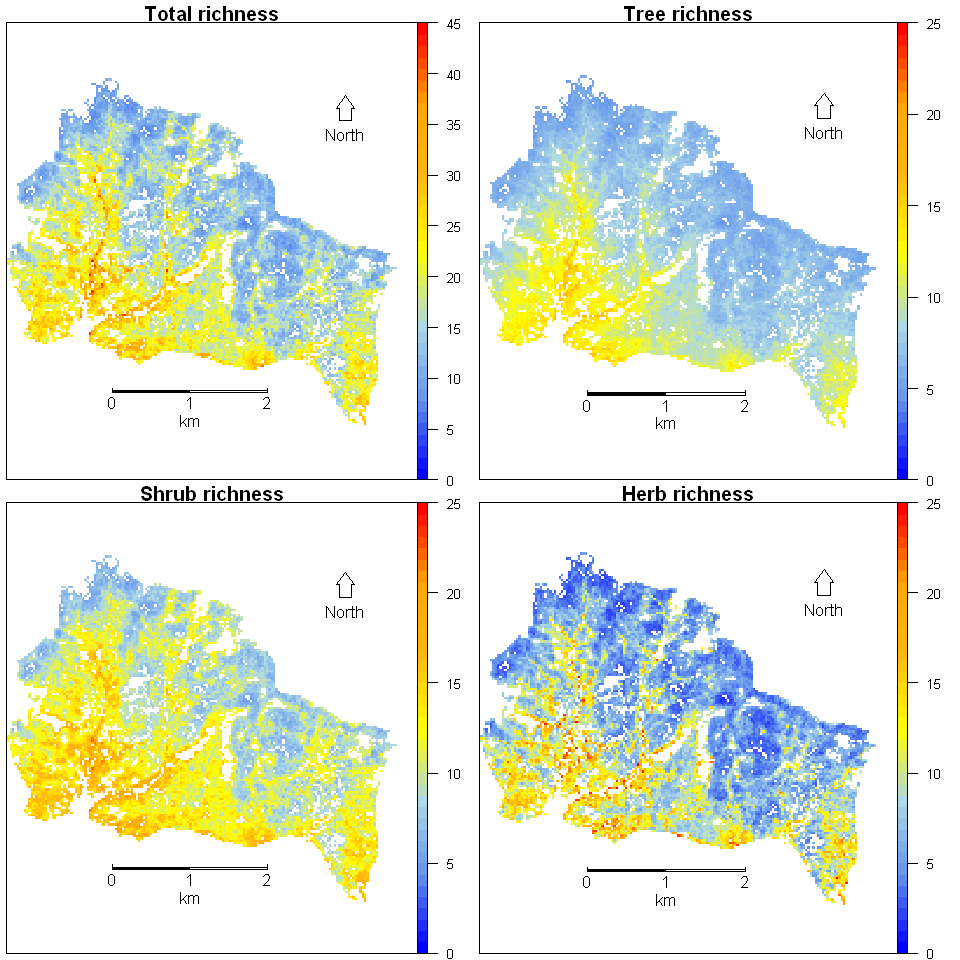

In [34]:
#pdf(file = "Figures/Fig 5 B&W.pdf", width=8, height=8)
# color version
color <- colorRampPalette(c("blue", "cornflowerblue", "lightblue", "yellow", "darkgoldenrod1", "orange", "red"))
# B&W version
#color <- colorRampPalette(c("gray100", "gray50", "gray10"))

par(mfrow=c(2,2), mai = c(0, 0, 0, 0))
# Total
par(mar=c(0, 0.3, 1, 0))
plot(preds_T, main="Total richness", col=color(40), zlim=c(0,45), axes=F, legend=T, legend.shrink=1, legend.width=1,
     axis.args=list(at=seq(0, 45, 5), labels=seq(0, 45, 5), cex.axis=0.8))
north.arrow(xb=326500,yb=6113800,len=80,lab="North")
map.scale(xc=324500,yc=6110300,len=2000,units="km", ndivs=2, scol = "black", sfcol =c("black", "white"))
# Tree
par(mar=c(0, 0, 1, 0))
plot(preds_A, main="Tree richness", col=color(40), zlim=c(0,25), axes=F, legend=T, legend.shrink=1, legend.width=1,
     axis.args=list(at=seq(0, 25, 5), labels=seq(0, 25, 5), cex.axis=0.8))
north.arrow(xb=326500,yb=6113800,len=80,lab="North")
map.scale(xc=324500,yc=6110300,len=2000,units="km", ndivs=2, scol = "black", sfcol =c("black", "white"))
# Shrub
par(mar=c(0.3, 0.3, 1, 0))
plot(preds_AR,  main="Shrub richness", col=color(40), zlim=c(0,25), axes=F, legend=T, legend.shrink=1, legend.width=1,
     axis.args=list(at=seq(0, 25, 5), labels=seq(0, 25, 5), cex.axis=0.8))
north.arrow(xb=326500,yb=6113800,len=80,lab="North")
map.scale(xc=324500,yc=6110300,len=2000,units="km", ndivs=2, scol = "black", sfcol =c("black", "white"))
# Herb
par(mar=c(0.3, 0, 1, 0))
plot(preds_H, main="Herb richness",  col=color(40), zlim=c(0,25),axes=F, legend=T, legend.shrink=1, legend.width=1,
     axis.args=list(at=seq(0, 25, 5), labels=seq(0, 25, 5), cex.axis=0.8))
north.arrow(xb=326500,yb=6113800,len=80,lab="North")
map.scale(xc=324500,yc=6110300,len=2000,units="km", ndivs=2, scol = "black", sfcol =c("black", "white"))
#dev.off()